# Analyse de sensibilité globale par regression - application au cas de la déviation verticale de la poutre


## Déviation  verticale d'une poutre encastrée

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">

__Inputs__:  $\left\{ E, F, L, I \right\} $
* $E$ : Young modulus (Pa)
* $F$ : Loading (N),
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4).

|Variable|  Distribution|
| ------------- |-------------|
|E|  Beta(r = 0.9, t = 3.5, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L|Uniform(min=250.0, max= 260.0)|
|I| Beta(r = 2.5, t = 4.0, a = 310, b = 450)|

In the previous table $\mu_F=E(F)$ and $\sigma_F=\sqrt{V(F)}$ are the mean and the standard deviation of $F$.

The input variables are supposed to be independent.

__Output__:

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$

## Références

- https://github.com/openturns/openturns/pull/904
- http://openturns.github.io/openturns/latest/theory/data_analysis/pearson_coefficient.html

# Model definition

In [1]:
import openturns as ot
import numpy as np

In [2]:
ot.ResourceMap.SetAsString('R-executable-command','C:\\Users\\c61372\\AppData\\Local\\Continuum\\anaconda3-5-3\\Lib\\R\\bin\\R.exe')

In [3]:
dist_E = ot.Beta(0.9, 3.1, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3) # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250., 260.) # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 4, 310., 450.) # in cm^4
dist_I.setDescription(["I"])

X = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [4]:
g = ot.SymbolicFunction( ["E","F","L","I"],["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un méchanisme d'historique.

In [5]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [6]:
XRV = ot.RandomVector(X)
Y = ot.RandomVector(g, XRV)
Y.setDescription(['Y (cm)'])

## Régression linéaire avec LinearLeastSquares

In [7]:
n = 1000
sampleX = X.getSample(n)
sampleY = g(sampleX)

In [8]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)

In [9]:
myLeastSquares.run()
responseSurface = myLeastSquares.getResponseSurface()
responseSurface

class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=LinearEvaluation name=Unnamed center=class=Point name=Unnamed dimension=4 values=[0,0,0,0] constant=class=Point name=Unnamed dimension=1 values=[0.000371894] linear=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-3.53343e-07,0.000422248,0.0985606,-0.0331838] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-3.53343e-07,0.000422248,0.0985606,-0.0331838] hessianImplementation=class=ConstantHessian name=Unnamed constant=class=SymmetricTensor implementation=class=TensorImplementation name=Unnamed rows=4 columns=4 sheets=1 values=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [10]:
val = ot.MetaModelValidation(sampleX, sampleY, responseSurface)

In [11]:
q2 = val.computePredictivityFactor()
q2

0.9761937158394096

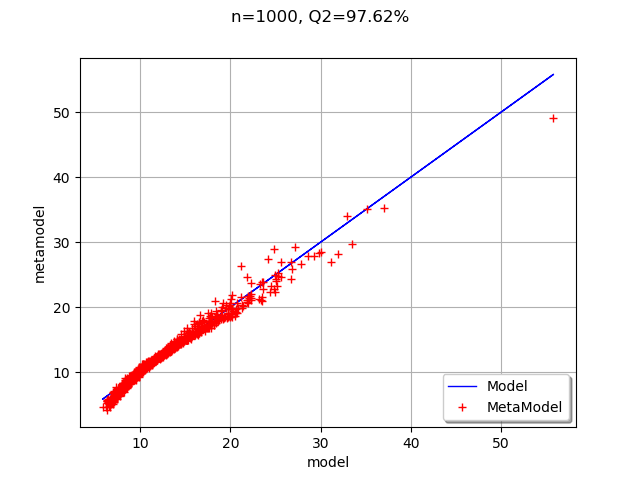

In [12]:
graph = val.drawValidation()
graph.setTitle("n=%d, Q2=%.2f%%" % (n,q2*100))
graph

In [13]:
SRCindices = ot.CorrelationAnalysis.SRC(sampleX, sampleY)
SRCindices

class=Point name=Unnamed dimension=4 values=[0.130762,0.811694,0.0105332,0.0470115]

On observe que la somme des indices SRC retournée par `SRC` est égale à 1. 

In [14]:
SRCindices.norm1()

0.9999999999999998

Or la part de variance qui n'est pas expliquée par le modèle linéaire dans ce cas est proche de 2%. Cela montre que les coefficients sont *normalisés* pour que la somme soit strictement égale à 1. Si ce n'était pas le cas, la somme serait égale à 0.98. 

Ce bug est corrigé dans :

https://github.com/openturns/openturns/pull/904

In [15]:
print(q2)
print(1-q2)

0.9761937158394096
0.023806284160590385


La méthode `DrawImportanceFactors` dans OT 1.12 produit un graphique camembert, qui peut mener à des conclusions erronées. La nouvelle fonction `DrawCorrelationCoefficients` corrige ce problème dans OT 1.13. En attendant, nous faisons un graphique à la main. 

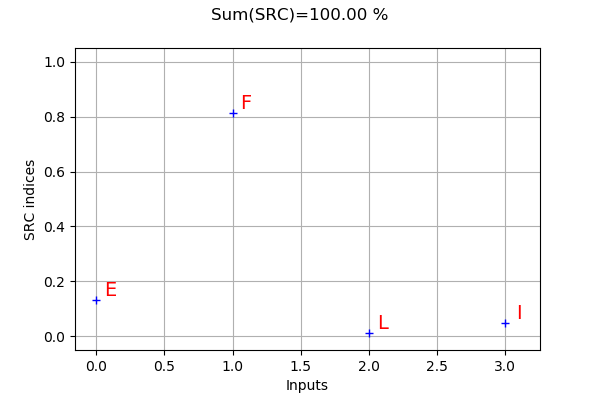

In [16]:
def drawSRCIndices(SRCindices,input_names):
    dim = SRCindices.getDimension()
    graph = ot.Graph('SRC indices', 'Inputs', 'SRC indices', True, '')
    datax = ot.Point(range(dim))
    deltax = 0.1 * ot.Point([1]*dim)
    cloud = ot.Cloud(datax,SRCindices)
    text = ot.Text(datax+deltax, SRCindices, input_names)
    text.setColor("red")
    graph.add(cloud)
    graph.add(text)
    bb = graph.getBoundingBox()
    lb = bb.getLowerBound()
    lb[1] = min(lb[1],-0.05)
    ub = bb.getUpperBound()
    ub[1] = max(ub[1],1.05)
    bb.setLowerBound(lb)
    bb.setUpperBound(ub)
    graph.setBoundingBox(bb)
    graph.setTitle("Sum(SRC)=%.2f %%" % (100*SRCindices.norm1()))
    return graph

input_names = g.getInputDescription()
drawSRCIndices(SRCindices,input_names)

Nous pouvons comparer les résultats que nous avions obtenu par la méthode du développement de Taylor. 

| Méthode | E | F | L | I |
|---|---|---|---|---|
| Taylor | 0.1535 | 0.7856 | 0.0101 | 0.0508 |
| Regression | 0.1307 | 0.8117 | 0.0105 | 0.0470 |

On peut remarquer que, dans ce cas particulier, les deux méthodes donnent des résultats très similaires. En effet, 
- la méthode fondée sur le développement de Taylor fait l'hypothèse locale d'un comportement linéaire au voisinage du point moyen $E(X)$,
- la méthode fondée sur la regression linéaire fait l'hypothèse globale d'un comportement linéaire sur le domaine du vecteur aléatoire $X$.

Puisque, dans notre application, la combinaison particulière des lois marginales et de la fonction $g$ mènent à un comportement approximativement linéaire, les deux méthodes produisent des résultats similaires.

## Exercice 1 : analyse graphique sur le cas poutre

L'objectif de cet exercice est d'observer l'évolution de Y en fonction de chaque marginale $X_i$. 

- Pour `i=0,...,3`, utiliser la classe `Cloud` pour dessiner l'échantillon de points avec `sampleX[:,i]` en abscisse et `sampleY` en ordonnées.
- Observez le graphique. Quelle variable d'entrée $X_i$ semble avoir le plus d'impact sur la variabilité de la variable de sortie $Y$ ? Quelle variable d'entrée semble n'avoir aucun impact sur la variabilité de $Y$ ?

## Exercice 2 : le coefficient de corrélation de Pearson

En complément des indices SRC, on utilise parfois les coefficients de corrélation de Pearson pour estimer la sensibilité :
$$
Corr(Y,X_i) = \frac{Cov(Y,X_i)}{\sqrt{V(Y)}\sqrt{V(X_i)}}
$$
pour $i=1,2,\ldots,p$.
En effet, ces coefficients permettent non seulement de quantifier la sensibilité, mais également d'obtenir le sens de variation de la sortie relativement à un changement dans chaque entrée. 
On utilise dans ce cas l'estimateur :
$$
\rho(Y,X_i) = \frac{\sum_{j=1}^n \left(y^{(j)}-\bar{y}\right)\left(x^{(j)}_i-\bar{x}_i\right)}{\sqrt{\sum_{j=1}^n \left(y^{(j)}-\bar{y}\right)^2}\sqrt{\sum_{j=1}^n \left(x^{(j)}_i-\bar{x_i}\right)^2}}
$$
pour $i=1,2,\ldots,p$, où :
$$
\bar{x}_i = \frac{1}{n} \sum_{j=1}^n x^{(j)}_i.
$$
Pour hiérarchiser les variables d'entrée selon ce critère, c'est la valeur absolue du coefficient de Pearson dont on tient compte. 

L'objectif de cet exercice est de calculer les coefficients de corrélation linéaire de Pearson pour estimer la sensibilité de la sortie.
- Créer la variable `sampleXY` contenant un `Sample` de taille $n$ et de dimension 5. Remplir les 4 premières colonnes avec `sampleX` et la dernière colonne par `sampleY`.
- Utiliser la méthode `computePearsonCorrelation` pour estimer les coefficients de corrélation de Pearson. Quelle hiérarchisation se dégage de ce critère ?
- Calculer les carrés de ces coefficients ; qu'observez-vous ?
- Calculer la somme de ces carrés ; qu'observez-vous ?

## Exercice 3 : application à une fonction jouet

On considère la fonction $g$ définie par :
$$
g(X_1,X_2,X_3) = X_1 (X_2-X_1)+X_3
$$
pour tout $X_1,X_2,X_3\in\mathbb{R}$. 
Les trois variables d'entrée sont supposées indépendante et suivre les lois gaussiennes spécifiées dans le tableau suivant.

| Variable | Distribution |
|---|---|
| $X_1$ | Normale($\mu_1=0.1$,$\sigma_1 = 1$) |
| $X_2$ | Normale($\mu_2=1$,$\sigma_2 = 2$) |
| $X_3$ | Normale($\mu_3=2$,$\sigma_3 = 0.2$) |

*Questions*
- Pour cette fonction, calculers les coefficients d'un modèle de régression linéaire au sens des moindres carrés.
- Ce modèle de régression est-il de bonne qualité ?

## Exercice 4 : modèle de poutre avec distributions élargies

On considère le cas de la déviation verticale de la poutre encastrée, dans lequel on modifie les paramètres des distributions marginales de $E$ et $F$. Les paramètres modifiés sont présentés dans la table ci-dessous.

|Variable|  Distribution|
| ------------- |-------------|
|E|  Beta(r = 0.9, t = 3.5, a = $1.0\times 10^7$, $b = 10.0\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=20\times 10^3$, shift=$15\times 10^3$)|
|L|Uniform(min=250.0, max= 260.0)|
|I| Beta(r = 2.5, t = 4.0, a = 310, b = 450)|

- Calculer les paramètres du modèle de régression linéaire pour ce nouveau modèle. 
- Calculer le coefficient de prédictivité $R^2$. Comment a-t-il évolué par rapport à la situation précédente ? Pourquoi ? Que conclure ?